# Demo for PAO-ML via e3nn

See also https://docs.e3nn.org/en/latest/guide/convolution.html

## Requirements:
```
pip install --upgrade e3nn matplotlib jaxtyping
```

In [1]:
from pao_model import PaoModel
from pao_dataset import PaoDataset, pao_loss_function
from e3nn import o3
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from pao_file_utils import parse_pao_file, write_pao_file, read_cp2k_energy

Number of parameters:  384


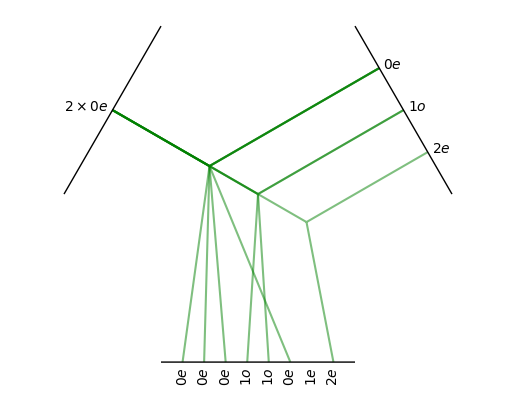

In [2]:
TRAINING_KIND = "H"

# Irreps of primary basis.
pao_basis_size = 4
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}

model = PaoModel(o3.Irreps(prim_basis_specs[TRAINING_KIND]), pao_basis_size, num_kinds=2)
model.tensor_product.visualize()
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

train_dataset = PaoDataset(kind=TRAINING_KIND, files=[Path("./2H2O_rotations/phi_00/2H2O_pao44-1_0.pao")])

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

optim = torch.optim.Adam(model.parameters())
num_steps = 5001
for step in range(num_steps):
    optim.zero_grad()
    for neighbors, features, label in train_dataloader:
        pred = model(neighbors, features)
        loss = pao_loss_function(pred, label)
        loss.backward()
    if step % 1000 == 0:
        print(f"training {step:5d} | loss {loss:.8e}")
    optim.step()

training     0 | loss 5.98372650e+00
training  1000 | loss 4.57987282e-03
training  2000 | loss 1.38800370e-03
training  3000 | loss 2.06956363e-04
training  4000 | loss 5.95816782e-05
training  5000 | loss 5.66477393e-05


# Validation

In [4]:
# Test against rotated training samples using loss functions
files = sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao"))[:10]
test_dataset = PaoDataset(kind=TRAINING_KIND, files=files)
for i, (neighbors, features, label) in enumerate(test_dataset):
    test_loss = pao_loss_function(model(neighbors, features), label)
    print(f"{i} lost: {test_loss:e}")

0 lost: 1.021835e-03
1 lost: 8.172932e-04
2 lost: 5.730111e-04
3 lost: 2.904994e-04
4 lost: 7.227140e-05
5 lost: 7.103152e-04
6 lost: 3.472287e-04
7 lost: 2.523845e-04
8 lost: 1.300681e-03
9 lost: 1.636327e-03
10 lost: 2.135058e-04
11 lost: 9.940319e-04
12 lost: 1.422576e-04
13 lost: 6.535428e-04
14 lost: 3.684521e-05
15 lost: 2.071388e-05
16 lost: 9.127245e-04
17 lost: 9.965615e-04
18 lost: 2.223795e-04
19 lost: 1.169431e-03
20 lost: 7.620085e-04
21 lost: 1.453984e-03
22 lost: 4.331940e-04
23 lost: 5.375665e-04
24 lost: 9.586196e-04
25 lost: 4.699556e-04
26 lost: 4.459714e-04
27 lost: 4.724162e-04
28 lost: 6.154077e-04
29 lost: 1.582137e-03
30 lost: 7.212954e-04
31 lost: 7.998995e-04
32 lost: 5.628326e-04
33 lost: 1.817430e-03
34 lost: 6.442828e-04
35 lost: 9.639479e-04
36 lost: 1.299584e-03
37 lost: 6.219622e-04
38 lost: 3.322329e-04
39 lost: 9.987276e-04


In [ ]:
# Test against randomly rotated training samples using CP2K.
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao"))[:10]:
    _, atom2kind, sample_coords, sample_xblocks = parse_pao_file(path)
    pred_xblocks = sample_xblocks.copy()
    for i, kind in enumerate(atom2kind):
        if kind == TRAINING_KIND:
            neighbors = sample_coords - sample_coords[i]
            # TODO move code into dataset
            features = np.array([(k == "H", k == "O") for k in atom2kind]) * len(atom2kind) ** 0.5
            pred_xblocks[i] = model(neighbors, features)
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 ~/git/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")